# Redes Adversáras Generativas (GANs)

O que são as redes adversárias gerativas? 🤔

As redes Adversárias Generativas possuem um grande potencial pois são capazes de gerar novos dados a partir de um conjunto de dados treinados. Podemos treinar essa rede para criar, por exemplo, novas imagens, músicas, falas, prosas, tratar resoluções de imagens e vídeos e muito mais. Uma das suas utilidades também pode ser criar novas imagens a partir de um conjunto de dados real para criar mais amostras de dados ao treinar uma rede neural convolucional.

Aplicações:
- Criação de imagens e áudios fakes;
- Reconstrução ou melhoria de imagens e animações;
- Aumento de resolução de imagens.

 Os algoritmos generativos tentam prever os recursos (dados) com um determinado rótulo. Por exemplo, dado que um e-mail é classificado como spam, qual é a probabilidade de palavras que formam esse e-mail spam? Os algoritmos discriminativos se preocupam com a correlação entre x e y, modelos generativos se preocupam em “como você irá obter x”.

Vamos utilizar base de dados MNIST de caracteres escritos manualmente, é um dataset já incluso no keras.

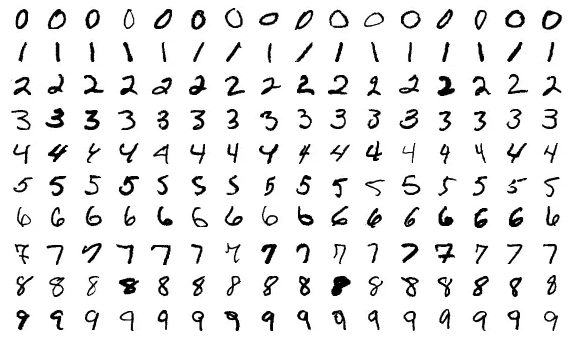

# Importando bibliotecas

In [1]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [4]:
import os
# Criação de gifs
import glob, imageio
import matplotlib.pyplot as plt
import numpy as np
# Manipulação de imagens
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import time
from IPython import display

# Aquisição base de dados

In [5]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [14]:
# Reshape, adiciona uma dimensão
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [15]:
# Normalização -1 e 1. Divide por 255/2
train_images = (train_images - 127.5) / 127.5

train_images

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

# Criando base de treinamento

In [17]:
# Tamanho do conjunto de dados
BUFFER_SIZE = train_images.shape[0]

# Qtde de pixels que varia
BATCH_SIZE = 256

In [18]:
# Criando base de treinamento
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

Basicamente as GANs são compostas por duas redes, a geradora e a discriminante. São chamadas de adversárias porque essas duas redes tentam “jogar” uma com a outra o tempo todo. 

A rede geradora tenta enganar a rede discriminante gerando dados fakes semelhantes aos dados reais.

O objetivo da rede discriminate aqui é reconhecer que os dígitos gerados a mão são o mais próximos possíveis dos verdadeiros números. 

A rede geradora tenta criar novas imagens fakes com a esperança de torná-las autênticas também (mesmo sendo falsas). O funcionamento da rede consiste nas seguintes etapas: O gerador considera números aleatórios e retornam uma imagem (ou seja, cria uma imagem fake); 

Essa imagem fake gerada pelo gerador é inserida no discriminador ao lado do fluxo de imagens verdadeiras geradas; o discriminador obtém imagens reais e falsas retornando a probabilidade realizando previsões de imagens falsas geradas pela rede generativa.

# Criação da rede geradora

Aqui temos o oposto de uma rede convolucional. Com o passar das camadas, a imagem aumenta de tamanho.

In [26]:
def make_generator_net():
    model = tf.keras.Sequential()
    # Entrada de um ruído randomico
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

    # Camada de normalização (z-score)
    model.add(BatchNormalization())

    # Função de ativação adaptada para os valores -1 e 1
    model.add(layers.LeakyReLU())

    # Reshape para deixar no formato da imagem
    model.add(layers.Reshape((7,7,256)))

    # None é o batch size
    assert model.output_shape == (None, 7, 7, 256)

    # Camada de convolução para aumentar a imagem e aplicar padding
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

## Criação primeira imagem aleatória

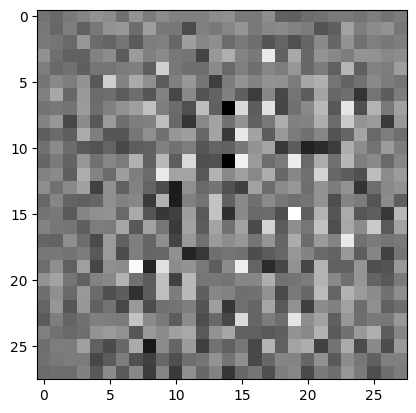

In [30]:
generator = make_generator_net()

# Ruído
noise = tf.random.normal([1, 100])

# Entrada na rede
generator_image = generator(noise, training=False)

plt.imshow(generator_image[0, :, :, 0], cmap='gray')

# Criação da rede discriminadora

In [32]:
# Basicamente uma rede CNN. Vai discriminar se a imagem é real ou fake

def make_discriminator_net():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(Dense(1))

    return model


In [41]:
discriminator = make_discriminator_net()

# Classificaçõ da imagem gerada
decision = discriminator(generator_image)

# 1 = Real, Negativos = Fake
print(decision)

tf.Tensor([[-0.00273746]], shape=(1, 1), dtype=float32)


# Configurando processo de treinamento

## Funções de custo

In [42]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [44]:
# função loss para o discriminador
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [45]:
# Avaliar fake gerado
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [46]:
# definindo o otimizador da função de custo Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Épocas de processamento

In [51]:
EPOCHS  = 35
noise_dim = 100
num_examples_generate = 16

seed = tf.random.normal([num_examples_generate, noise_dim])

## Função com passos do treinamento

In [52]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Gerando imagens fake
        generated_images = generator(noise, training=True)

        # Discriminador em imagens fake e reais
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculando perdas gerador e discriminador
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Cálculo de gradientes com relação aos parâmetros
    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

## Função de execução do treinamento

In [54]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        # Salva modelo a cada 15 épocas
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f'Tempo de execução da época {epoch+1}: {time.time() - start} segundos')

    # Gerador final
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

## Função para gerar e salvar imagens

In [55]:
# função para definir as imagens

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('imagem_epoch_{:04d}.png'.format(epoch))
  plt.show

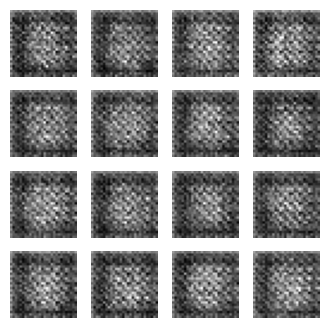

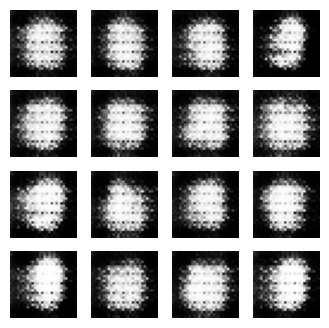

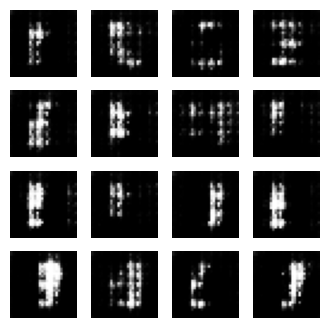

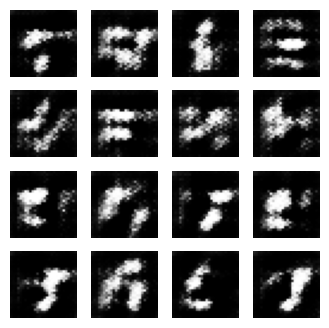

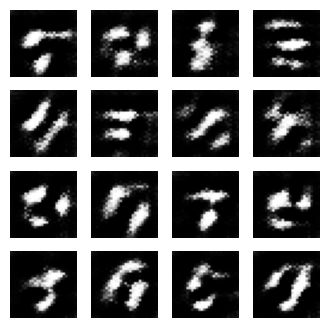

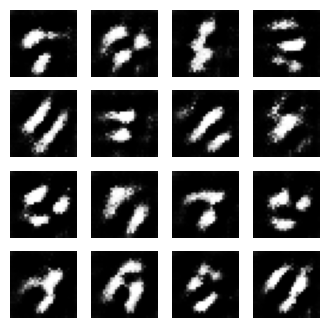

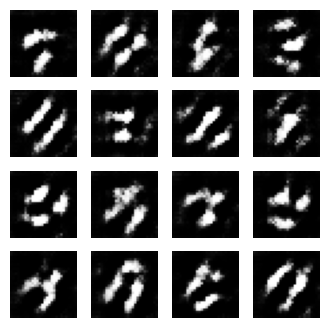

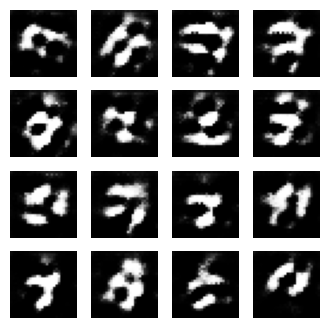

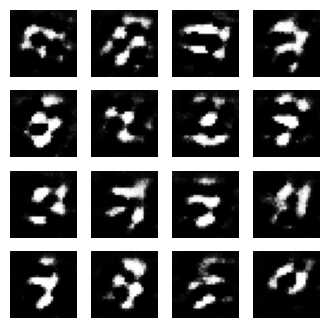

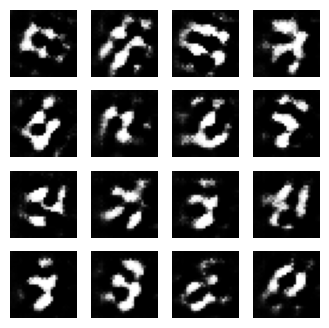

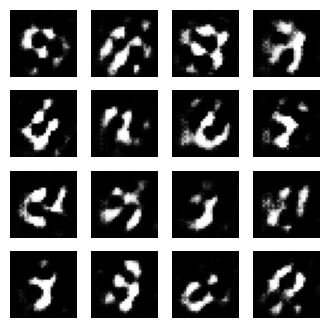

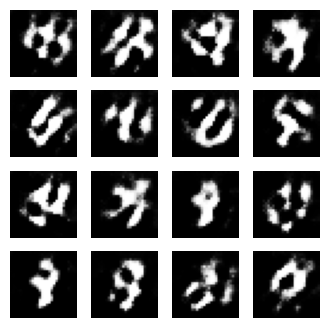

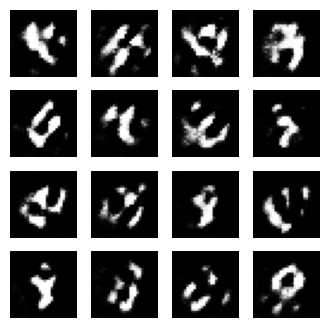

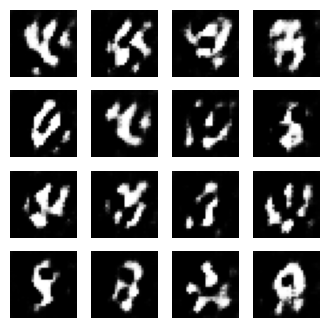

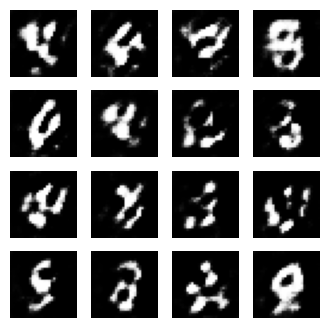

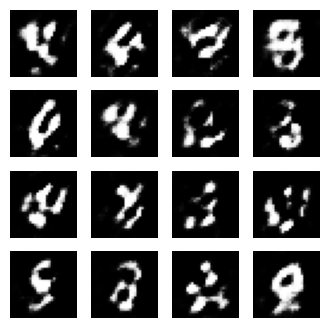

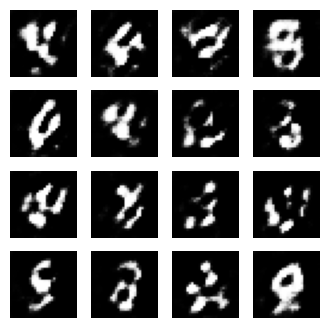

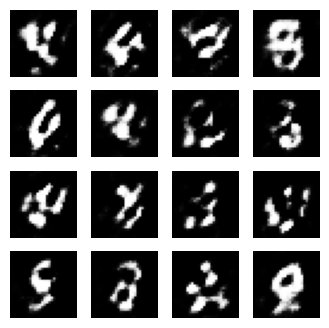

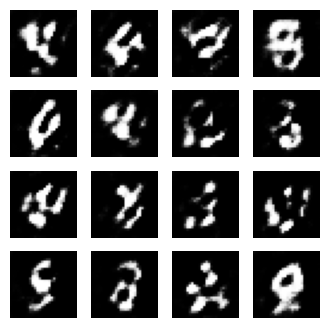

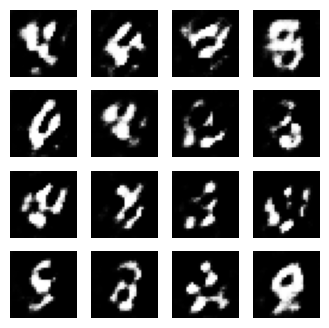

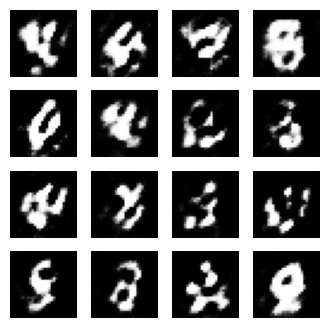

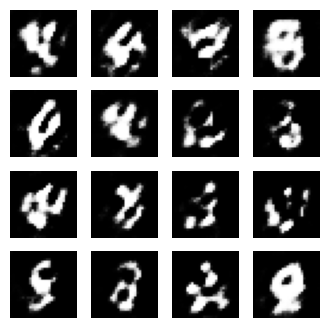

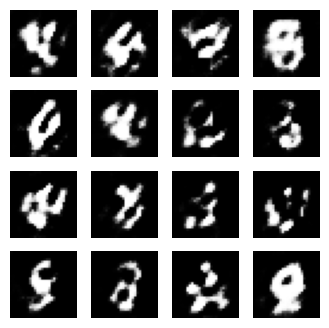

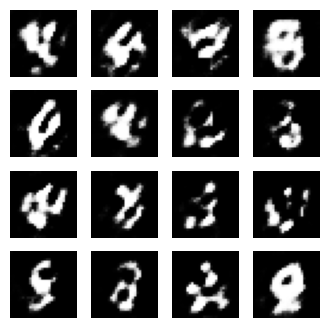

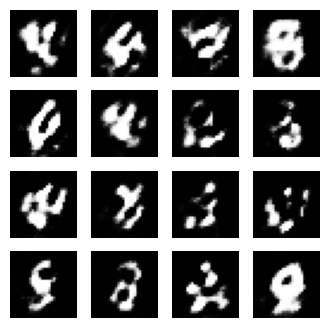

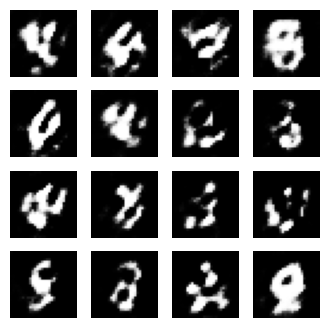

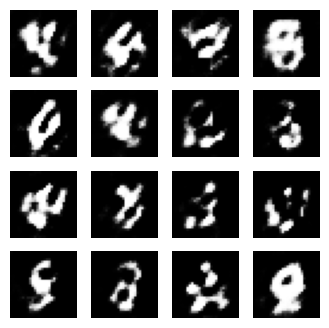

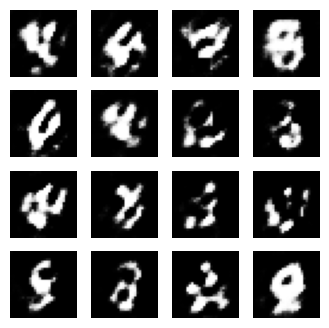

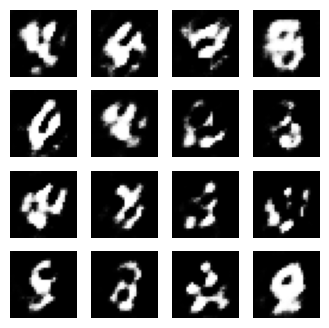

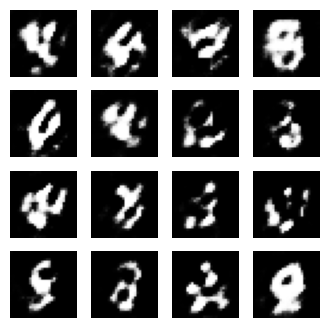

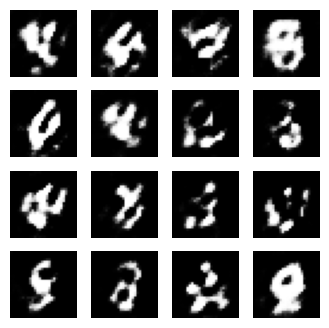

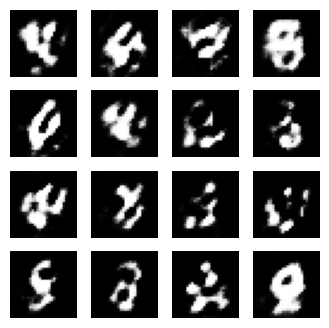

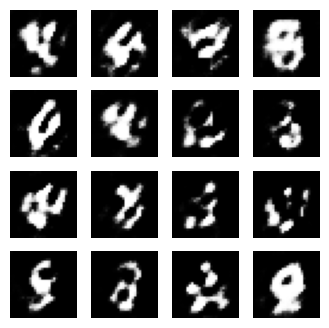

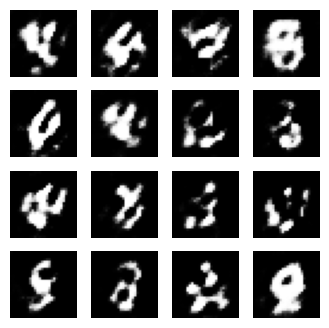

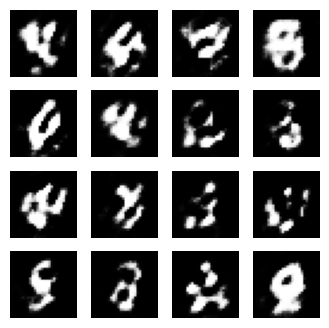

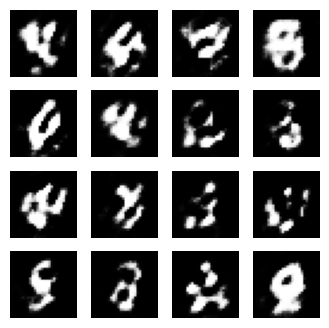

In [58]:
train(train_dataset, EPOCHS)